In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from dataset import NYUDataset
from custom_transforms import *
import plot_utils
import numpy as np
import model_utils
from nn_model import Net
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
%matplotlib inline
import torch.nn.functional as F

In [2]:
#3x640x480 in dataset,   CxWxH
#480x640x3 for plotting, HxWxC
#3x480x640 for pytorch,  CxHxW  

In [3]:
bs = 8
sz = (320,240)
seed = np.random.seed(1)
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = torch.tensor(mean), torch.tensor(std)
unnormalize = UnNormalizeImgBatch(mean, std)
tfms = transforms.Compose([
    ResizeImgAndDepth(sz),
    RandomHorizontalFlip(),
    ImgAndDepthToTensor(),
    NormalizeImg(mean, std)
])
ds = NYUDataset('data/', tfms)
dl = torch.utils.data.DataLoader(ds, bs, shuffle=True)
train_loader, val_loader, test_loader = ds.create_split_loaders(bs, seed, tfms,0.1, 0.1,True)

In [4]:
ds[0][0].shape

torch.Size([3, 240, 320])

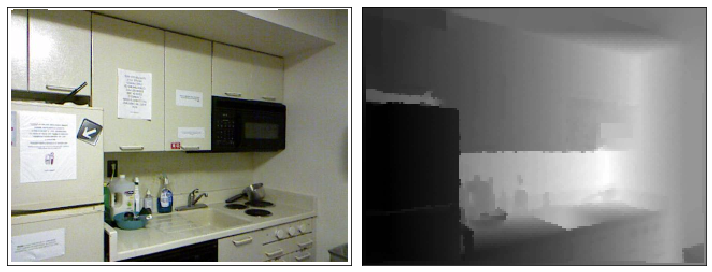

In [5]:
i = 1
plot_utils.plot_image(model_utils.get_unnormalized_ds_item(unnormalize, ds[i]))

#sample_batch = iter(dl).next()
#img, depth = sample_batch

In [6]:
model = Net()
model.to(device)

Net(
  (VGG): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256,

In [7]:
model.load_state_dict(torch.load('all-scales-trained.ckpt', map_location="cpu"))
#model_utils.freeze_all_layers(model.VGG)
#model_utils.freeze_all_layers(model.Scale_1)
#model_utils.freeze_all_layers(model.Scale_2)

In [8]:
final_loss_val=[]
final_mse_loss_val=[]
final_l1_loss_val=[]
final_berhu_loss_val=[]
def validate(model,final_loss_val,final_mse_loss_val,final_l1_loss_val,final_berhu_loss_val):
    for batch_val, labels in val_loader:   
        batch = batch_val.to(device)
        labels = labels.to(device)
        model.eval()
        preds = model(batch)
        loss = model_utils.depth_loss(preds, labels) 
        mse_loss= model_utils.MaskedMSELoss(preds, labels)
        l1_loss=model_utils.MaskedL1Loss(preds, labels)
        berhu_loss=model_utils.berHuLoss(preds, labels)
        final_loss_val.append(loss.item())
        final_mse_loss_val.append(mse_loss.item())
        final_l1_loss_val.append(l1_loss.item())
        final_berhu_loss_val.append(berhu_loss.item())
        

In [9]:
model.train()
n_epochs = 10
lr = 0.0000005
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)
final_loss=[]
final_mse_loss=[]
final_l1_loss=[]
final_berhu_loss=[]
total_steps = 0
for e in range(n_epochs):
    for data_train in train_loader:
        batch,labels=data_train
        
        optimizer.zero_grad()
        
        batch = batch.to(device)
        labels = labels.to(device)
        
        preds = model(batch)
        loss = model_utils.depth_loss(preds, labels) 
        final_loss.append(loss.item())
        mse_loss= model_utils.MaskedMSELoss(preds, labels)
        final_mse_loss.append(mse_loss.item())
        l1_loss=model_utils.MaskedL1Loss(preds, labels)
        final_l1_loss.append(l1_loss.item())
        berhu_loss=model_utils.berHuLoss(preds, labels)
        final_berhu_loss.append(berhu_loss.item())
        loss.backward()
        optimizer.step()
        total_steps +=1
        model_utils.print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(train_loader))
    del batch
    del labels
    optimizer.zero_grad()
    validate(model,final_loss_val,final_mse_loss_val,final_l1_loss_val,final_berhu_loss_val)
       
                                                       
        

Epoch [1/10], Iteration [1/147], Loss: 3.1762
Epoch [1/10], Iteration [10/147], Loss: 3.0111
Epoch [1/10], Iteration [20/147], Loss: 3.1836
Epoch [1/10], Iteration [30/147], Loss: 4.4055
Epoch [1/10], Iteration [40/147], Loss: 3.1372
Epoch [1/10], Iteration [50/147], Loss: 4.3506
Epoch [1/10], Iteration [60/147], Loss: 2.8722
Epoch [1/10], Iteration [70/147], Loss: 2.5633
Epoch [1/10], Iteration [80/147], Loss: 4.1544
Epoch [1/10], Iteration [90/147], Loss: 3.5237
Epoch [1/10], Iteration [100/147], Loss: 2.8659
Epoch [1/10], Iteration [110/147], Loss: 4.2289
Epoch [1/10], Iteration [120/147], Loss: 5.2167
Epoch [1/10], Iteration [130/147], Loss: 2.6666
Epoch [1/10], Iteration [140/147], Loss: 2.8351
Epoch [1/10], Iteration [0/147], Loss: 2.5884
Epoch [2/10], Iteration [1/147], Loss: 2.7413
Epoch [2/10], Iteration [10/147], Loss: 3.3449
Epoch [2/10], Iteration [20/147], Loss: 3.0204
Epoch [2/10], Iteration [30/147], Loss: 2.3491
Epoch [2/10], Iteration [40/147], Loss: 2.9062
Epoch [2/10

In [10]:
torch.save(model.state_dict(),'all-scales-trained_new.ckpt')

In [22]:
%%time
with torch.no_grad():
    model.eval()
    img, depth = iter(test_loader).next()
    preds = model(img.to(device))

CPU times: user 7.19 s, sys: 31.9 ms, total: 7.22 s
Wall time: 1.77 s


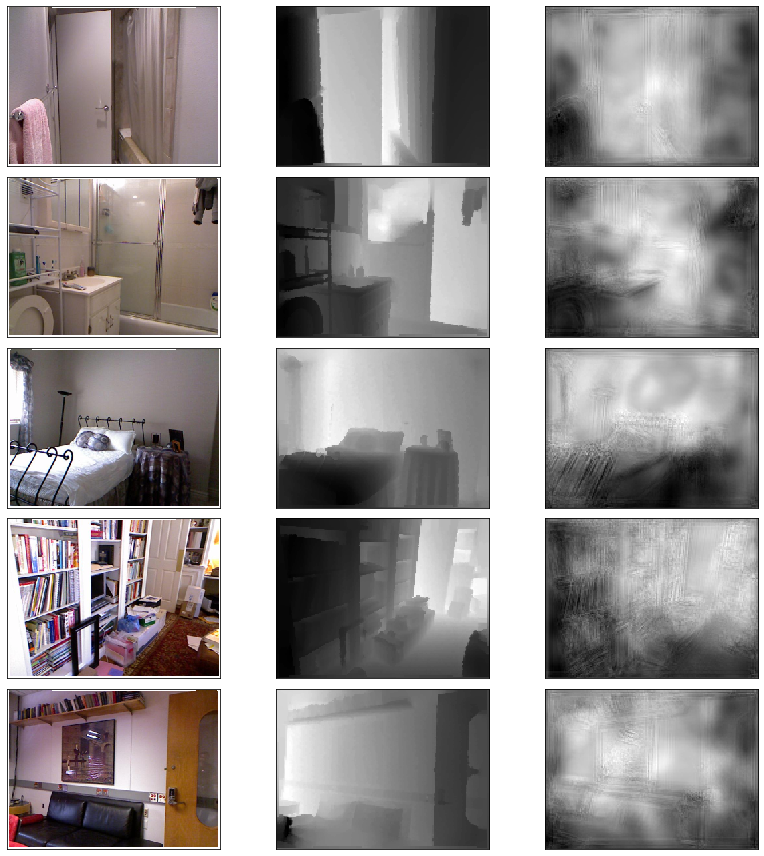

In [23]:
plot_utils.plot_model_predictions_on_sample_batch(images=unnormalize(img), depths=depth, preds=preds.squeeze(dim=1), plot_from=0)

In [13]:
test_tfms = transforms.Compose([
    transforms.Resize((240,320)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [14]:
import PIL
from PIL import Image

im = Image.open('IMG_4120.jpg').rotate(180)
res = test_tfms(im)

model.eval()
pred = model(res[None].to(device))

In [15]:
pred_numpy_arr = pred.detach().squeeze(dim=1).squeeze(dim=0).cpu().numpy()
pred_numpy_arr = pred_numpy_arr - pred_numpy_arr.min()       # -0.660375
pred_numpy_arr = (pred_numpy_arr/pred_numpy_arr.max())*255   # max = 2.1548061, brings scale to 0-255  
pred_numpy_arr = pred_numpy_arr.astype('uint8')

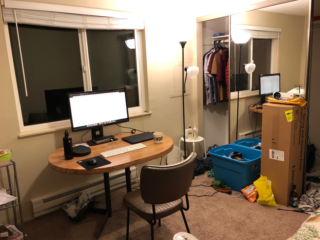

In [16]:
im.resize((320,240), resample=PIL.Image.BILINEAR)

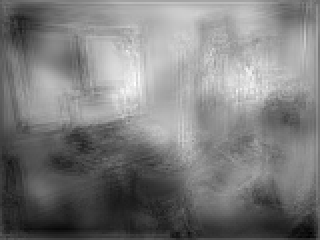

In [17]:
Image.fromarray(pred_numpy_arr, mode = 'L').resize((320, 240))

In [18]:
T, P = transforms.ToTensor(), transforms.ToPILImage()
dx, dy, g = model_utils.apply_sobel_operator_on_sample_ds_image(ds[10], unnormalize, T, P)

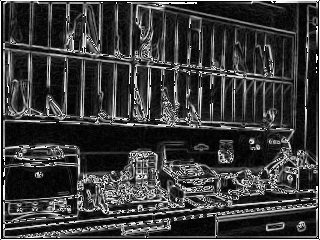

In [19]:
P(g)

In [20]:
from IPython.display import FileLink
FileLink('all-scales-trained.ckpt')

/datasets/home/home-00/02/402/gkarumur/Depth-Map-Prediction-from-a-Single-Image-using-a-Multi-Scale-Deep-Network/all-scales-trained.ckpt

In [21]:
final_loss_val

[4.190670013427734,
 3.13706111907959,
 2.688591480255127,
 3.3733866214752197,
 3.041935443878174,
 3.1870594024658203,
 1.8625741004943848,
 4.115049362182617,
 2.52970027923584,
 3.2146849632263184,
 3.0550405979156494,
 3.4486083984375,
 3.1335561275482178,
 3.3242568969726562,
 3.034616231918335,
 2.873718500137329,
 2.2747254371643066,
 2.6813650131225586,
 2.593754529953003,
 3.0348148345947266,
 2.0702600479125977,
 3.201460361480713,
 2.3540704250335693,
 3.762477159500122,
 2.126917600631714,
 2.805379867553711,
 2.320389986038208,
 3.1969351768493652,
 2.6517434120178223,
 2.546226978302002,
 3.9868762493133545,
 3.3180088996887207,
 3.1214137077331543,
 2.27669620513916,
 3.3094241619110107,
 2.9194912910461426,
 2.042067289352417,
 3.696192741394043,
 2.059605121612549,
 3.1721973419189453,
 2.565183162689209,
 3.340960741043091,
 2.3594741821289062,
 2.8612687587738037,
 2.9768319129943848,
 3.2565484046936035,
 1.898583173751831,
 1.789489507675171,
 3.301755428314209,
 